In [1]:
from typing import Annotated 
import operator
from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model
import os
from uuid import uuid4
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_KEY")
os.environ["LANGSMITH_ENDPOINT"] = os.getenv("LANGSMITH_ENDPOINT",
                                             "https://api.smith.langchain.com")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = os.getenv("LANGSMITH_PROJECT", "Enginimate")

## Create Reasoning Agent

In [5]:
llm = init_chat_model("groq:openai/gpt-oss-20b", temperature=0.7)

system_prompt = """You are an expert senior Python developer \
specializing in the Manim animation library.  
Your task is to plan out the detailed, step-by-step process \
required to implement a scene in Manim based on the description provided.

Requirements:
1. Break down the scene into clear, actionable, and mutually exclusive \
steps for implementation. Remember mutual exclusiveness is IMPORTANT.
2. Include what objects, animations, and transitions will be used.
3. Mention any special camera movements or effects if they enhance visual appeal.
4. Describe the order of execution logically, from setup to rendering.
5. Avoid writing actual Manim code — focus only on the planning and structure.
"""

prompt_template = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("user", "{scene_description}"),
])

# Worker Input
class WorkerStep(BaseModel):
    step_id: int = Field(default=0, description="Step number for scene creation")
    description: str = Field(default="", description="Description of the step")

class WorkerSteps(BaseModel):
    steps: list[WorkerStep] = Field(default_factory=list,
                                    description="Steps required for scene creation")

class WorkerOutput(BaseModel):
    step_id: int = Field(default=0, description="Step number for scene creation")
    url: str = Field(default="", description="Uploaded URL of the generated video")

class WorkerState(BaseModel):
    step_id: int = Field(default=0, description="Step number for scene creation")
    description: str = Field(default="", description="Description of the step")
    docs: str = Field(default="", description="Most relevant documentation of manim \
to assist in writing python code using manim-ce library for the given description")
    feedback: str = Field(default="", description="Feedback to improve the python code")
    code: str = Field(default="", description="Generated python code using manim-ce \
library for the given description")
    code_retry_or_not: str = Field(default="", description="Whether to retry code \
generation or not")
    url: str = Field(default="", description="Uploaded URL of the generated video")
    completed_steps: Annotated[list[WorkerOutput], operator.add] = Field(
        default_factory=list,
        description="List of completed steps with their outputs",
    )  # Workers write to this in parallel, list of WorkerOutput

class State(BaseModel):
    uuid: str = Field(default=uuid4().hex, description="Unique identifier for client")
    prompt: str = Field(default="", description="User prompt for scene generation")
    steps: list[WorkerStep] = Field(default_factory=list,
                                    description="List of planned steps for the scene")
    completed_steps: Annotated[list[WorkerOutput], operator.add] = Field(
        default_factory=list,
        description="List of completed steps with their outputs",
    )  # Workers write to this in parallel, list of WorkerOutput
    success: bool = Field(default=True,
                          description="Indicates if the pipeline completed successfully")
    error_message: str = Field(default="",
                               description="Error message if the pipeline failed")
    sorted_urls: list[str] = Field(default_factory=list,
                                   description="List of video URLs sorted by step_id")

def orchestrator(state: State):
    planner = llm.with_structured_output(WorkerSteps)
    pipeline = prompt_template | planner
    worker_steps = pipeline.invoke({
        "scene_description": state.prompt
    })
    return {
        "steps": worker_steps.steps
    }

def sample_worker(state: WorkerState): 
    step_id = state["step_id"]
    description = state["description"]
    print(f"Processing Step {step_id}: {description}")
    # TODO: Implement actual video generation logic here
    # sample output
    op = WorkerOutput(step_id=step_id,
                      url=f"https://example.com/video_step_{step_id}.mp4")
    return {
        "completed_steps": [op]
    }

def synthesizer(state: State):
    # Sort URLs based on step_id
    sorted_steps = sorted(state.completed_steps, key=lambda x: x.step_id)
    sorted_urls = [step.url for step in sorted_steps]
    return {
        "sorted_urls": sorted_urls
    }

def assign_workers(state: State):
    return [Send("sample_worker", {"step_id": step.step_id, "description": step.description}) for step in state.steps]

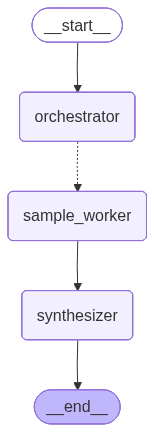

In [6]:
from IPython.display import display, Image
# define nodes and edges
workflow = StateGraph(State)

workflow.add_node("orchestrator", orchestrator)
workflow.add_node("sample_worker", sample_worker)
workflow.add_node("synthesizer", synthesizer)

workflow.add_edge(START, "orchestrator")
workflow.add_conditional_edges(
    "orchestrator", assign_workers, ["sample_worker"]
)
workflow.add_edge("sample_worker", "synthesizer")
workflow.add_edge("synthesizer", END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
state = graph.invoke({
    "prompt": "Create a scene that visually approximates the value of Pi (π) by \
calculating the area of a unit circle (A=πr2, with r=1, so A=π) using \
the Monte Carlo method"
})
print(state["sorted_urls"])

Processing Step 1: Create a square of side length 2 centered at the origin to represent the bounding box of the unit circle.
Processing Step 2: Create a unit circle centered at the origin inside the square.
Processing Step 3: Define a parameter for the total number of random points (e.g., 500 or 1000).
Processing Step 4: Generate a list of random (x, y) coordinates uniformly distributed within the square.
Processing Step 5: For each point, create a Dot object: color it green if it lies inside the unit circle, otherwise color it red.
Processing Step 6: Animate the points appearing one by one (or in small batches) to illustrate the Monte Carlo sampling process.
Processing Step 7: After all points have been plotted, compute the ratio of green dots to total points and multiply by 4 to estimate π.
Processing Step 9: Optionally, add a small graph or list that updates the π estimate after each batch of points to show convergence.
Processing Step 8: Create a MathTex or Text object to display t